In [2]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from collections import Counter
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split

In [3]:
# Load Data
def load_ml100k():
    df = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
    df = df.drop(columns=['timestamp'])
    df['user_id'] -= 1
    df['item_id'] -= 1

    user_id = df['user_id'].values
    item_id = df['item_id'].values
    rating = df['rating'].values

    user_id_train, user_id_test, item_id_train, item_id_test, y_train, y_test = train_test_split(
        user_id, item_id, rating, test_size=0.2, random_state=42
    )

    user_id_train = torch.tensor(user_id_train, dtype=torch.long)
    item_id_train = torch.tensor(item_id_train, dtype=torch.long)
    y_train = torch.tensor(y_train - 1, dtype=torch.long)

    user_id_test = torch.tensor(user_id_test, dtype=torch.long)
    item_id_test = torch.tensor(item_id_test, dtype=torch.long)
    y_test = torch.tensor(y_test - 1, dtype=torch.long)

    return (user_id_train, item_id_train, y_train), (user_id_test, item_id_test, y_test)

In [4]:
# 1. Implement the ClassificationModel class
class ClassificationModel(nn.Module):
    def __init__(self, embedding_size, max_user_id, max_item_id):
        super().__init__()
        self.user_embedding = nn.Embedding(max_user_id + 1, embedding_size)
        self.item_embedding = nn.Embedding(max_item_id + 1, embedding_size)
        self.fc1 = nn.Linear(embedding_size * 2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.dropout = nn.Dropout(0.2)
        self.output = nn.Linear(32, 5)

    def forward(self, inputs):
        user, item = inputs
        u_emb = self.user_embedding(user)
        i_emb = self.item_embedding(item)
        x = torch.cat([u_emb, i_emb], dim=1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.output(x)
        return F.softmax(x, dim=1)

In [5]:
# Custom_Loss_Function_With_Regularization
def custom_loss(probs, targets, weights, model, reg_lambda):
    ce_loss = F.cross_entropy(probs, targets, weights)
    reg_term = sum(torch.norm(param, p=2) for name, param in model.named_parameters() if "embedding" in name)
    return ce_loss + reg_lambda * reg_term

In [6]:
# Custom MAE, MSE Calculation
def manual_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def manual_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

In [7]:
# 2. Complete the training and evaluation code
def train_and_evaluate(use_custom_loss=True):
    (user_id_train, item_id_train, y_train), (user_id_test, item_id_test, y_test) = load_ml100k()
    max_user_id = max(user_id_train.max(), user_id_test.max()).item()
    max_item_id = max(item_id_train.max(), item_id_test.max()).item()

    # Dataset and DataLoader
    dataset = TensorDataset(user_id_train, item_id_train, y_train)
    val_size = int(0.2 * len(dataset))
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64)
    test_loader = DataLoader(TensorDataset(user_id_test, item_id_test, y_test), batch_size=64)
    
    # Initialize model
    model = ClassificationModel(embedding_size=32, max_user_id=max_user_id, max_item_id=max_item_id)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    counts = Counter(y_train.tolist())
    weights = torch.tensor([1.0 / math.sqrt(counts[i]) for i in range(5)], dtype=torch.float)
    reg_lambda = 1e-4

    train_losses, val_losses = [], []
    for epoch in range(20):
        model.train()
        total_loss = 0
        for user, item, rating in train_loader:
            optimizer.zero_grad()
            output = model((user, item))
            if use_custom_loss:
                loss = custom_loss(output, rating, weights, model, reg_lambda)
            else:
                loss = F.cross_entropy(output, rating, weights)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_losses.append(total_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for user, item, rating in val_loader:
                output = model((user, item))
                if use_custom_loss:
                    loss = custom_softmax_loss(output, rating, weights, model, reg_lambda)
                else:
                    loss = F.cross_entropy(output, rating, weights)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

    # TODO: Plot training and validation loss curves
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f"Loss Curve - {'Custom Loss' if use_custom_loss else 'Cross Entropy'}")
    plt.show()

    # Evaluate model
    def get_predictions(loader):
        preds, labels = [], []
        with torch.no_grad():
            for user, item, rating in loader:
                output = model((user, item))
                pred = output.argmax(dim=1) + 1
                preds.extend(pred.tolist())
                labels.extend((rating + 1).tolist())
        return np.array(preds), np.array(labels)

    train_preds, train_labels = get_predictions(DataLoader(dataset, batch_size=64))
    test_preds, test_labels = get_predictions(test_loader)

    # TODO: Calculate and print MSE and MAE for train and test sets
    print("Train MAE:", manual_mae(train_labels, train_preds))
    print("Train MSE:", manual_mse(train_labels, train_preds))
    print("Test MAE:", manual_mae(test_labels, test_preds))
    print("Test MSE:", manual_mse(test_labels, test_preds))

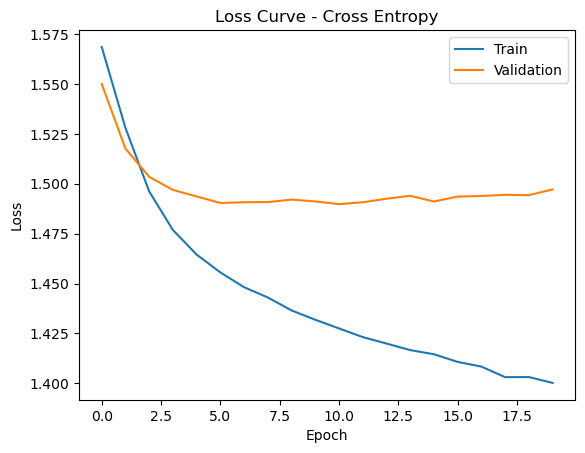

Train MAE: 0.663725
Train MSE: 1.1375
Test MAE: 0.77885
Test MSE: 1.29495


NameError: name 'custom_softmax_loss' is not defined

In [8]:
# Run custom and CE loss models
train_and_evaluate(use_custom_loss=False)
train_and_evaluate(use_custom_loss=True)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import roc_auc_score
import pandas as pd
from sklearn.model_selection import train_test_split

# Helper: Load data and create positive interaction dict

def load_implicit_data():
    df = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
    df['user_id'] -= 1
    df['item_id'] -= 1
    df = df[df['rating'] >= 4]  # Treat rating >= 4 as implicit positive feedback
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

    def build_dict(d):
        result = {}
        for row in d.itertuples():
            result.setdefault(row.user_id, set()).add(row.item_id)
        return result

    return build_dict(train_df), build_dict(test_df), df['user_id'].nunique(), df['item_id'].nunique()

# 1. Complete the MLP class
class MLP(nn.Module):
    def __init__(self, input_dim, n_hidden=1, hidden_size=64, dropout=0.):
        super().__init__()
        layers = [nn.Dropout(dropout)]
        for _ in range(n_hidden):
            layers.append(nn.Linear(input_dim, hidden_size))
            layers.append(nn.ReLU())
            input_dim = hidden_size
        layers.append(nn.Linear(input_dim, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x).squeeze(-1)

# 2. Margin Loss
class MarginLoss(nn.Module):
    def __init__(self, margin):
        super().__init__()
        self.margin = margin

    def forward(self, pos_score, neg_score):
        return torch.mean(F.relu(neg_score - pos_score + self.margin))

# 3. DeepTripletModel
class DeepTripletModel(nn.Module):
    def __init__(self, n_users, n_items, user_dim=32, item_dim=64, margin=1., 
                 n_hidden=1, hidden_size=64, dropout=0, l2_reg=None):
        super().__init__()
        self.user_layer = nn.Embedding(n_users, user_dim)
        self.item_layer = nn.Embedding(n_items, item_dim)
        self.mlp = MLP(user_dim + item_dim, n_hidden, hidden_size, dropout)
        self.margin_loss = MarginLoss(margin)

    def forward(self, user_ids, pos_item_ids, neg_item_ids):
        u = self.user_layer(user_ids)
        ip = self.item_layer(pos_item_ids)
        ineg = self.item_layer(neg_item_ids)
        pos_input = torch.cat([u, ip], dim=1)
        neg_input = torch.cat([u, ineg], dim=1)
        pos_score = self.mlp(pos_input)
        neg_score = self.mlp(neg_input)
        return self.margin_loss(pos_score, neg_score)

# 4. DeepMatchModel
class DeepMatchModel(nn.Module):
    def __init__(self, user_layer, item_layer, mlp):
        super().__init__()
        self.user_layer = user_layer
        self.item_layer = item_layer
        self.mlp = mlp

    def forward(self, user_ids, item_ids):
        u = self.user_layer(user_ids)
        i = self.item_layer(item_ids)
        return self.mlp(torch.cat([u, i], dim=1))

# 5. Evaluation

def average_roc_auc(model, pos_data_test, n_users, n_items):
    model.eval()
    all_auc = []
    with torch.no_grad():
        for user in range(n_users):
            pos_items = pos_data_test.get(user, set())
            if not pos_items:
                continue
            y_true, y_score = [], []
            for item in range(n_items):
                y_true.append(1 if item in pos_items else 0)
                score = model(torch.LongTensor([user]), torch.LongTensor([item])).item()
                y_score.append(score)
            if len(set(y_true)) > 1:
                auc = roc_auc_score(y_true, y_score)
                all_auc.append(auc)
    return np.mean(all_auc) if all_auc else 0.0

# 6. Triplet Sampler

def sample_triplets(pos_data, n_users, n_items, batch_size):
    user_ids, pos_ids, neg_ids = [], [], []
    for _ in range(batch_size):
        user = np.random.randint(0, n_users)
        pos = list(pos_data.get(user, []))
        if not pos:
            continue
        pos_item = np.random.choice(pos)
        neg_item = np.random.randint(0, n_items)
        while neg_item in pos_data.get(user, set()):
            neg_item = np.random.randint(0, n_items)
        user_ids.append(user)
        pos_ids.append(pos_item)
        neg_ids.append(neg_item)
    return (torch.LongTensor(user_ids), torch.LongTensor(pos_ids), torch.LongTensor(neg_ids))

# 7. Training Loop

def train_deep_recsys():
    pos_data_train, pos_data_test, n_users, n_items = load_implicit_data()

    hyper_parameters = {
        'user_dim': 32,
        'item_dim': 64,
        'n_hidden': 1,
        'hidden_size': 128,
        'dropout': 0.1,
        'l2_reg': 0.,
        'margin': 1.0
    }

    model = DeepTripletModel(n_users, n_items, **hyper_parameters)
    match_model = DeepMatchModel(model.user_layer, model.item_layer, model.mlp)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(20):
        model.train()
        user_ids, pos_ids, neg_ids = sample_triplets(pos_data_train, n_users, n_items, batch_size=256)
        optimizer.zero_grad()
        loss = model(user_ids, pos_ids, neg_ids)
        loss.backward()
        optimizer.step()

        auc = average_roc_auc(match_model, pos_data_test, n_users, n_items)
        print(f"Epoch {epoch+1}/20, Loss: {loss.item():.4f}, Test ROC AUC: {auc:.4f}")
train_deep_recsys()